## VCB

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu (Không có thay đổi)
data = pd.read_csv('../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu 
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (80/20) 
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra 
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình MLP
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) # Lớp Dense đầu tiên
model.add(Dense(50, activation='relu'))                            # Lớp Dense ẩn
model.add(Dense(n_forecast))                                       # Lớp Dense đầu ra
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra 
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Dự đoán tương lai 
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0409
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5117e-04
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9355e-04
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9121e-04
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1316e-04
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4851e-04
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9273e-04
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5264e-04
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2545e-04
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0547e-04
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8933e-04
Epoch 13/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7873e-04
Epoch 14/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7879e-04
Epoch 15/100
57/57 ━━━━

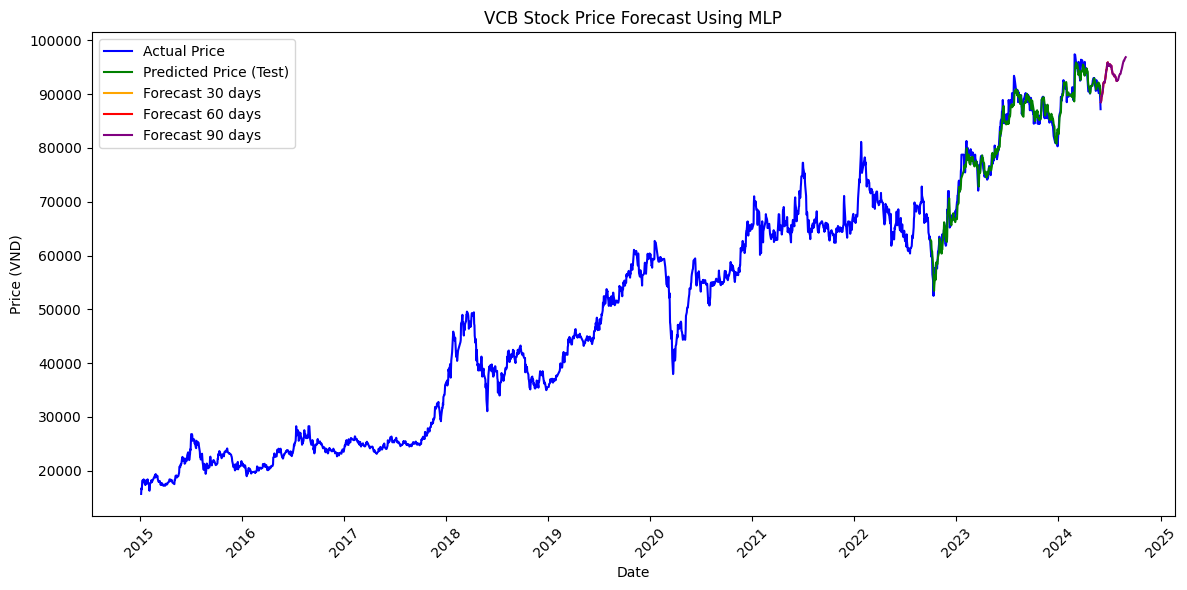

In [2]:
# Trực quan hóa
plt.figure(figsize=(12, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index, df['Price'], label='Actual Price', color='blue')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predicted Price (Test)', color='green')

# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Forecast 30 days', color='orange')
plt.plot(future_dates[:60], future_predictions[:60], label='Forecast 60 days', color='red')
plt.plot(future_dates, future_predictions, label='Forecast 90 days', color='purple')

plt.title('VCB Stock Price Forecast Using MLP')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu VCB trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu VCB trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  88537.656250
2024-06-02  88719.523438
2024-06-03  89288.445312
2024-06-04  89795.140625
2024-06-05  89751.757812
...                  ...
2024-08-25  96457.132812
2024-08-26  96614.242188
2024-08-27  96718.460938
2024-08-28  96783.250000
2024-08-29  96867.921875

[90 rows x 1 columns]


In [4]:
# Tính RMSE, MAPE, và MDA trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mda = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mda

rmse, mape, mda = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MDA:', mda)

RMSE: 1500.8925575190597
MAPE: 1.4453561766143186 %
MDA: 1141.3660290287994


## CTG

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu (Không có thay đổi)
data = pd.read_csv('../Dataset/CTG.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu 
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (80/20) 
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra 
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình MLP
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) # Lớp Dense đầu tiên
model.add(Dense(50, activation='relu'))                            # Lớp Dense ẩn
model.add(Dense(n_forecast))                                       # Lớp Dense đầu ra
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra 
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Dự đoán tương lai 
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0742
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0696e-04
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3271e-04
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7310e-04
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1753e-04
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4877e-04
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0909e-04
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0869e-04
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4445e-04
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9880e-04
Epoch 13/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6175e-04
Epoch 14/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5289e-04
Epoch 15/100
57/57 ━━━━━━━━

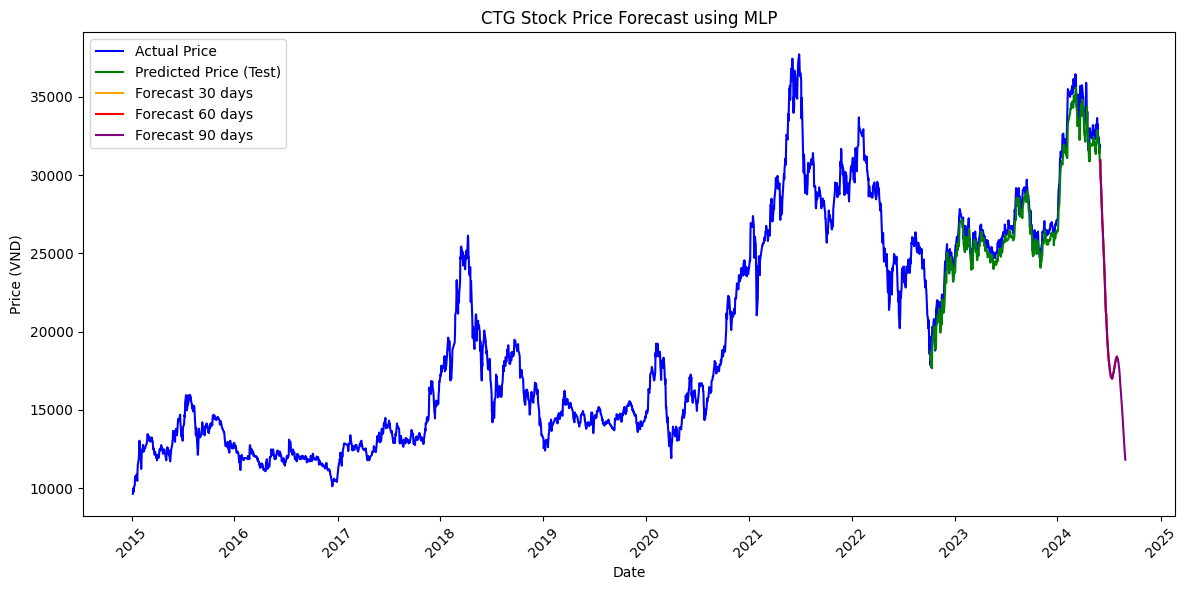

In [6]:
# Trực quan hóa
plt.figure(figsize=(12, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index, df['Price'], label='Actual Price', color='blue')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predicted Price (Test)', color='green')

# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Forecast 30 days', color='orange')
plt.plot(future_dates[:60], future_predictions[:60], label='Forecast 60 days', color='red')
plt.plot(future_dates, future_predictions, label='Forecast 90 days', color='purple')

plt.title('CTG Stock Price Forecast using MLP')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu CTG trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu CTG trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  30948.925781
2024-06-02  29920.251953
2024-06-03  29654.664062
2024-06-04  29186.685547
2024-06-05  28696.873047
...                  ...
2024-08-25  12841.291992
2024-08-26  12542.154297
2024-08-27  12291.069336
2024-08-28  12038.106445
2024-08-29  11826.946289

[90 rows x 1 columns]


In [8]:
# Tính RMSE, MAPE, và MDA trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mda = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mda

rmse, mape, mda = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MDA:', mda)

RMSE: 882.2797403662906
MAPE: 2.7175719386749586 %
MDA: 744.7216486476161


## BID

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu (Không có thay đổi)
data = pd.read_csv('../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu 
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (80/20) 
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra 
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình MLP
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) # Lớp Dense đầu tiên
model.add(Dense(50, activation='relu'))                            # Lớp Dense ẩn
model.add(Dense(n_forecast))                                       # Lớp Dense đầu ra
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra 
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Dự đoán tương lai 
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0381
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2946e-04
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3323e-04
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5699e-04
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4035e-04
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3607e-04
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0959e-04
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2573e-04
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0670e-04
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0570e-04
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0829e-04
Epoch 13/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0533e-04
Epoch 14/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0727e-04
Epoch 15/100
57/57 ━━━━

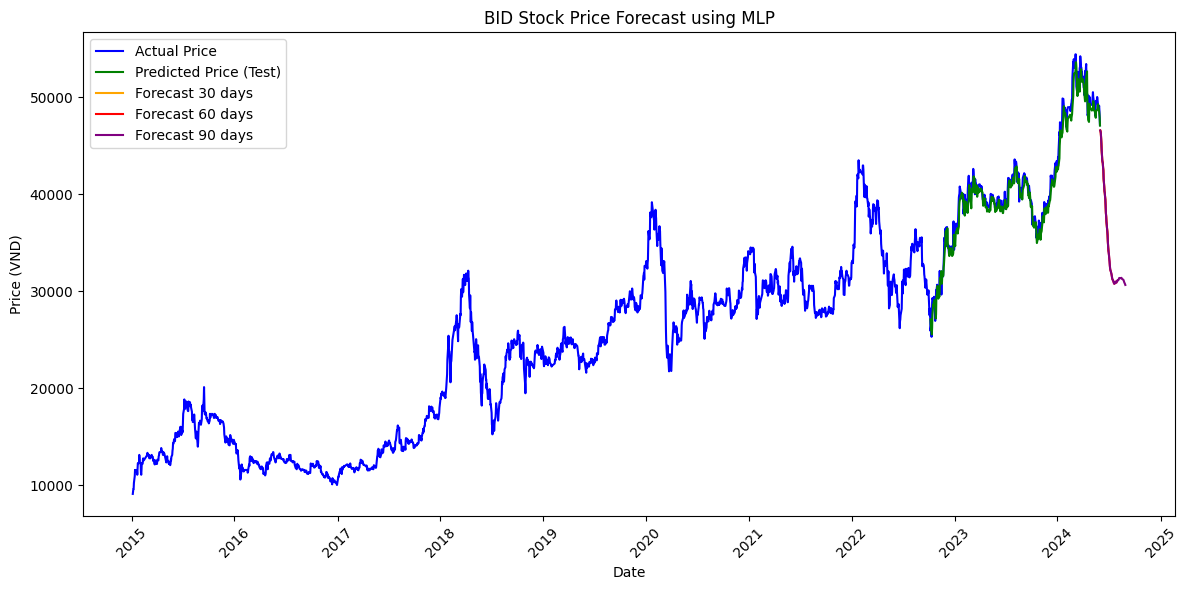

In [10]:
# Trực quan hóa
plt.figure(figsize=(12, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index, df['Price'], label='Actual Price', color='blue')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predicted Price (Test)', color='green')

# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Forecast 30 days', color='orange')
plt.plot(future_dates[:60], future_predictions[:60], label='Forecast 60 days', color='red')
plt.plot(future_dates, future_predictions, label='Forecast 90 days', color='purple')

plt.title('BID Stock Price Forecast using MLP')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu BID trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu BID trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  46550.238281
2024-06-02  46469.218750
2024-06-03  46293.078125
2024-06-04  45769.398438
2024-06-05  45191.773438
...                  ...
2024-08-25  30919.496094
2024-08-26  30852.523438
2024-08-27  30784.982422
2024-08-28  30718.941406
2024-08-29  30635.226562

[90 rows x 1 columns]


In [12]:
# Tính RMSE, MAPE, và MDA trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mda = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mda

rmse, mape, mda = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MDA:', mda)

RMSE: 1011.8773467588761
MAPE: 1.8897271959314295 %
MDA: 769.0679582441932
